<div align="right" style="text-align: right"><i>Peter Norvig<br>March 2021</i></div>

# The Square-Sum Chain Problem

The Square-Sum Chain Problem is this:

> Arrange the integers 1 to *n* in a linear chain such that each adjacent pair of numbers adds up to a perfect square.

The problem is oft-discussed (e.g., [Numberphile](https://www.youtube.com/watch?v=G1m7goLCJDY), [reddit](https://www.reddit.com/r/dailyprogrammer/comments/7t6fnc/20180126_challenge_348_hard_find_chains/), [MAA](https://www.maa.org/sites/default/files/pdf/awards/college.math.j.46.4.264.pdf), OEIS  [A090460](https://oeis.org/A090460), [A090461](https://oeis.org/A090461) [A071983](https://oeis.org/A071983), [A071984](https://oeis.org/A071984)). There are several variants:

1. Given *n*, find a valid chain.
2. Given *n*, count the number of valid chains.
3. Do this efficiently, for all *n* from 1 up to a largish bound.
4. Prove what happens as *n* goes to infinity.
5. Do the above with a [circular chain](https://www.tutorialspoint.com/statistics/circular_permutation.htm).
6. Do the above with [cubes](https://math.stackexchange.com/questions/1168983/arranging-numbers-from-1-to-n-such-that-the-sum-of-every-two-adjacent-number) (or higher powers) instead of  squares.

# Vocabulary

Some vocabulary/definitions for this problem:
- **Chain**: an ordered list of integers 1 to *n* (a permutation of 1 to *n*), where each adjacent pair sums to a perfect square.
- **Circular chain**: a chain that loops back on itself so the first and last integers are considered to be adjacent.
- ***n***: the size of the chain.
- ***i, j***: integers  in the chain.
- **Partial chain**: a list of fewer than *n* integers (used to build up to a complete chain). 
- **Adjacency Graph**: a [graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29) with links between each pair of integers *i* and *j* that could be adjacent in a chain. We represent the graph as a dict, `A`, where, say, `A[2] = [7, 14]` means that 7 and 14 are the integers that can be adjacent to 2 (this would be true for all *n* between 14 23).

# Imports, Type Definitions, and Utility Functions

Let's get these out of the way first:

In [1]:
from math        import sqrt, sin, cos, pi as 𝜋
from typing      import *
from collections import Counter, defaultdict
import random
import time
import matplotlib.pyplot as plt

In [2]:
Chain = list                 # A square-sum chain of integers, e.g. [8, 1, 15, ...]
Graph = Dict[int, List[int]] # Adjacency graph, e.g. {1: [3, 8, 15], 2: [7, 14], ...}

In [3]:
def ints(n) -> range: "Integers from 1 to n."; return range(1, n + 1)

def first(iterable): "First element, or None."; return next(iter(iterable), None)

def length(iterable) -> int: "Number of elements."; return sum(1 for _ in iterable)

# Depth-First Search Algorithm to Find Chains 

A complete chain is a path through the adjacency graph that reaches each vertex (integer) once. That's known as a [Hamiltonian path](https://en.wikipedia.org/wiki/Hamiltonian_path). We can search for a chain with a [depth-first search](https://en.wikipedia.org/wiki/Depth-first_search) algorithm: start at one integer in the graph, follow a link to an adjacent integer, from there to another unused adjacent integer, etc. Whenever you hit a dead end, back up. I'll define `find_chains(n)` to do the depth-first search to find all chains of length `n`:
  - Compute `graph = adjacency_graph(n)`: a `dict` `{i: [j, ...], ...}` to say that *i* and *j* can be adjacent in a chain.
  - Assign `stack` to be a stack of partial chains; initially all the chains with just one integer in them.
  - Now do a depth-first search: on each pass through the main loop, pop a partial chain off the stack, and do the following with it:
    - If it is a complete chain (of length `n`), yield it as a result.
    - Otherwise, add new chains to the stack, one for each integer `j` in the adjacency graph that can be added to the current partial chain.
 

Here's the code:

In [4]:
def find_chains(n) -> Iterator[Chain]:
    """Yield all chains of 1..n rearranged so every adjacent pair sums to a square."""
    graph = adjacency_graph(n)
    stack = [[i] for i in graph]
    while stack:
        chain = stack.pop()
        if len(chain) == n:
            yield chain
        else:
            stack.extend([chain + [j] for j in graph[chain[-1]] if j not in chain])

def adjacency_graph(n) -> Graph:
    """Build {i: [j, ...]} to indicate that j can be adjacent to i."""
    return {i: [j for j in ints(n) if i != j and sqrt(i + j).is_integer()]
            for i in ints(n)}

# Some Questions and Answers

First question: why did I define `find_chains` to be a [generator function](https://docs.python.org/3/howto/functional.html#generators)?  Because that way a single function can be used both to efficiently find a single chain for a given *n*, and to exhaustively find all chains for a given *n*. For example, here is `find_chain` being used to answer four different questions about the case of *n* = 15: 

In [5]:
n = 15

In [6]:
any(find_chains(n))    # Is there any solution for n?

True

In [7]:
first(find_chains(n))  # What is the first solution?

[9, 7, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8]

In [8]:
length(find_chains(n)) # How many solutions are there?

2

In [9]:
list(find_chains(n))   # What are they?

[[9, 7, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8],
 [8, 1, 15, 10, 6, 3, 13, 12, 4, 5, 11, 14, 2, 7, 9]]

One more question:

In [10]:
adjacency_graph(n)     # What is the adjacency graph for n?

{1: [3, 8, 15],
 2: [7, 14],
 3: [1, 6, 13],
 4: [5, 12],
 5: [4, 11],
 6: [3, 10],
 7: [2, 9],
 8: [1],
 9: [7],
 10: [6, 15],
 11: [5, 14],
 12: [4, 13],
 13: [3, 12],
 14: [2, 11],
 15: [1, 10]}

Note that integers 8 and 9 each have only one  integer in their adjacency list–they are **singletons**. This implies that **8 and 9 must be the two ends of the chain**. Furthermore, an adjacency graph with more than two singletons has no solution (as a does a graph where some integer has no adjacent numbers). Also, a circular chain cannot be made for any graph with a singleton.


# Circular Chains

Now let's handle circular chains. I'll modify `find_chains` to take an optional argument, `circular`, that defaults to false, but when true causes the function to  yield only the chains that are circular chains.

This does bring up the question of what it means for two chains to be the same or different. If the sequence ABCD represents a circle, then BCDA is in some sense the same circle, just rotated. Maybe it is wasteful to yield all *n* rotations of a circle? I'll use the convention that for circular chains, I'll only consider chains whose first element is 1. I will however still yield both ABCD and DCBA, even though they are in some sense the same chains, only reversed.

In [11]:
def find_chains(n, circular=False) -> Iterator[Chain]:
    """Yield all chains of 1..n rearranged so every adjacent pair sums to a square.
    If `circular` is true, then chain[0] and chain[-1] are considered adjacent."""
    graph = adjacency_graph(n)
    stack = [[i] for i in ({1} if circular else graph)]
    while stack:
        chain = stack.pop()
        if len(chain) == n and (is_circular(chain) or not circular):
            yield chain
        elif len(chain) < n:
            stack.extend([chain + [j] for j in graph[chain[-1]] if j not in chain])
            
def is_circular(chain) -> bool: return sqrt(chain[0] + chain[-1]).is_integer()

What's the smallest *n* that has a valid circular chain?

In [12]:
first(n for n in ints(100) if any(find_chains(n, circular=True)))

32

# Making it Faster


I'll run `find_chains` over the first 50 values of *n*, count how many have solutions, and see how long it takes to do the computations:

In [13]:
%time sum(any(find_chains(n)) for n in ints(50))

CPU times: user 1min 17s, sys: 40.2 ms, total: 1min 17s
Wall time: 1min 17s


31

It took over a minute to find answers just up to *n* = 50. Can we speed things up? Well, if we want to find *all* solutions for a given *n*, the fundamental issue is that there are a lot of permutations to search through.

However, if we are only interested in the *first* solution, there is more hope. We can change the **order** that we consider integers, to try to make it more likely that the first solution shows up earlier in the search. What order would be better? One in which we handle the most-constrained hard-to-match integers first–the integers with few links in the adjacency graph. That way, a singleton will be handled first, as it should be, and the search will quickly make many moves with little need to back up. For example, on the adjacency graph for *n* = 15, the integer 9 is a singleton so it comes first, followed by 7, which must be followed by 2 (since 9 is used), which must be followed by 14 (since 7 us used), which must be followed by 11 (since 2 is used), and so on. 

I implement the reordering within `adjacency_graph` with `reorder`, which uses the `link_count`  as the key, but note that I have to reverse the results, because the stack is last-in-first-out, so I need to append the lowest-link-count integer last, so that it will be popped off the stack first.

In [14]:
def adjacency_graph(n) -> Graph:
    """{i: [j, ...]} with i's sorted least connections first; j's sorted most first."""
    graph = {i: [j for j in ints(n) if i != j and sqrt(i + j).is_integer()]
            for i in ints(n)}
    def link_count(i): return len(graph[i])
    def reorder(integers): return sorted(integers, key=link_count, reverse=True)
    return {i: reorder(graph[i]) for i in reorder(graph)}

In [15]:
adjacency_graph(n) # Reordered with the singleton 9 last; each list is reordered as well.

{1: [3, 15, 8],
 3: [1, 6, 13],
 2: [7, 14],
 4: [5, 12],
 5: [4, 11],
 6: [3, 10],
 7: [2, 9],
 10: [6, 15],
 11: [5, 14],
 12: [4, 13],
 13: [3, 12],
 14: [2, 11],
 15: [1, 10],
 8: [1],
 9: [7]}

Will this reordering give us a good speedup?

In [16]:
%time sum(any(find_chains(n)) for n in range(50))

CPU times: user 878 ms, sys: 2.31 ms, total: 881 ms
Wall time: 880 ms


30

That was a nice improvement! Nearly 100× faster! 

I have one other idea I want to try, but I'm only hoping for a 10% or 20% improvement, not 100×. The idea is to manage a bitstring to represent the set of integers in the chain, so that `j not in chain` is O(1), not O(*n*). 

Instead of the stack entry `[9, 7, 2]`, we would have `([9, 7, 2], 0b1010000100)`. I'll also change the `stack.extend` to a `stack.append` inside a `for` loop and an `if` statement. I don't think that will be faster, but the statement won't fit on one line anymore, so it might be easier to read broken up into several lines like this.

In [17]:
def find_chains(n, circular=False) -> Iterator[Chain]:
    """Yield all chains of 1..n rearranged so every adjacent pair sums to a square.
    If `circular` is true, then chain[0] and chain[-1] are considered adjacent."""
    graph = adjacency_graph(n)
    stack = [([i], 1 << i) for i in ((1,) if circular else graph)]
    while stack:
        chain, bits = stack.pop()
        if len(chain) == n and (is_circular(chain) or not circular):
            yield chain
        elif len(chain) < n:
            for j in graph[chain[-1]]:
                if not (bits & (1 << j)):
                    stack.append((chain + [j], bits | (1 << j)))

In [18]:
%time sum(any(find_chains(n)) for n in range(50))

CPU times: user 510 ms, sys: 1.69 ms, total: 512 ms
Wall time: 511 ms


30

That's close to 40% improvement, so better than I hoped for.

The faster version of `find_chains` still gets the same answers:

In [19]:
list(find_chains(n)) 

[[9, 7, 2, 14, 11, 5, 4, 12, 13, 3, 6, 10, 15, 1, 8],
 [8, 1, 15, 10, 6, 3, 13, 12, 4, 5, 11, 14, 2, 7, 9]]

In [20]:
first(n for n in ints(100) if any(find_chains(n, circular=True)))

32

If you are only interested in finding a single solution for a given *n* rather than counting all solutions, try:

- Instead of reordering the adjacency lists once and for all at the start of the search, dynamically update the counts (and thus the ordering of the lists) as integers are used in partial chains.
- Use [heuristic search](https://en.wikipedia.org/w/index.php?title=Heuristic_search) rather than depth-first search.
- Use [hillclimbing search](https://en.wikipedia.org/wiki/Hill_climbing) to modify a partial solution. You could have the search for a solution for *n* begin with a solution chain for *n - 1*, and search in the space of edit operations on that chains: insert *n* into that chain; cut a chain into  two parts; reversing a part; append two parts together; etc. (I believe this is the best hope for going beyond *n* = 100 in a reasonable amount of time.)

# Visualization

I'd like to understand more about chains, with an emphasis on circular ones. Visualizartions can help. The function `show` takes as input either an adjacency graph or a chain of size *n*, and does the following:
- Plot the integers 1 to *n* as vertices in a circle, in clockwise order like a clock face.
- Plot lines between integers to indicate a link (the links in a chain, or all the links in an adjacency graph).
  - All lines with the same *i* + *j* sum will be of the same color, and be parallel to each other.
- Print the number of vertices with each [*degree*](https://en.wikipedia.org/wiki/Degree_%28graph_theory%29). <br> (`{1: 2, 2: 11, 3: 1}` means there are 2 vertices that have 1 link;  11 vertices that have two links; and 2 vertices that have 3 links.)
- Print the number of links that sum up to each perfect square.<br>(`{4: 1, 9: 4, 16: 7, 25: 3}` means that there is 1 link whose integers sum to 4; 4 that sum to 9; 7 that sum to 16; and 3 that sum to 25.)

In [21]:
def show(graph: Union[Graph, Chain], fmt='-', colors='ckyrgmb'):
    if isinstance(graph, Chain):
        graph = graph_of(graph)
    n = max(graph)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.axis('off')
    𝛼 = 2 * 𝜋 / n
    X = [sin(𝛼 * i) for i in ints(n)]
    Y = [cos(𝛼 * i) for i in ints(n)]
    for i in graph:             
        for j in graph[i]:      # Draw edges
            color = colors[int(sqrt(i + j)) % len(colors)]
            plt.plot([X[i-1], X[j-1]], [Y[i-1], Y[j-1]], color + fmt)
    ax.scatter(X, Y, color='k') # Draw vertices
    for i in ints(n):           # Draw numbers next to vertices
        vertex = (X[i - 1] * 1.1 - 0.02, Y[i - 1] * 1.1 - 0.02)
        ax.annotate(i, vertex, annotation_clip=False)
    def ctr(seq): return dict(sorted(Counter(seq).items())) # sorted Counter
    print(f'Degree counts: {ctr(map(len, graph.values()))}')
    print(f'Square counts: {ctr(i + j for i in graph for j in graph[i] if i > j)}')

def graph_of(chain: Chain) -> Graph:
    """Convert a chain, [i, j, ...] to a graph, {i: [j, ...], ...}."""
    graph = defaultdict(list)
    links = [(chain[k - 1], chain[k])
             for k in range(1 - is_circular(chain), len(chain))]
    for i, j in links:
        graph[i].append(j)
        graph[j].append(i)
    return graph

# Visualizing a linear chain for *n* = 15

Degree counts: {1: 2, 2: 11, 3: 2}
Square counts: {4: 1, 9: 4, 16: 7, 25: 3}


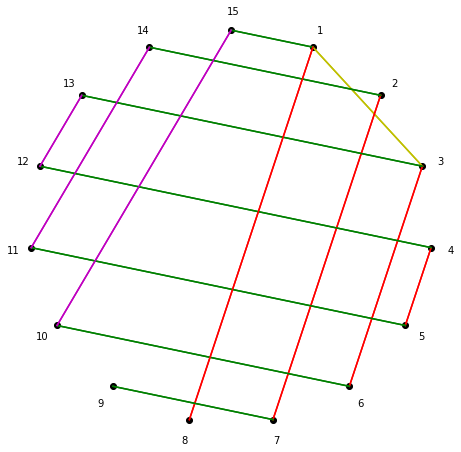

In [22]:
show(adjacency_graph(15))

The adjacency graph for *n* = 15 clearly shows that 9 and 8 are singletons. There are also 11 different integers with  2 links each, meaning that their position in the chain is fixed–there is no choice about who their neighbors will be. The only choice points are the two integers that each have 3 links: 1 and 3.

Here's the chain for *n* = 15:

Degree counts: {1: 2, 2: 13}
Square counts: {9: 4, 16: 7, 25: 3}


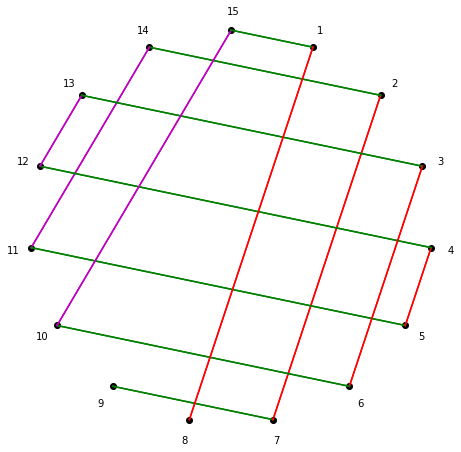

In [23]:
show(first(find_chains(15)))

We see that the solution chain is the same as the adjacency graph with the one link between 1 and 3 omitted.

# Visualizing a circular chain for *n* = 32




Degree counts: {2: 10, 3: 16, 4: 6}
Square counts: {4: 1, 9: 4, 16: 7, 25: 12, 36: 14, 49: 8}


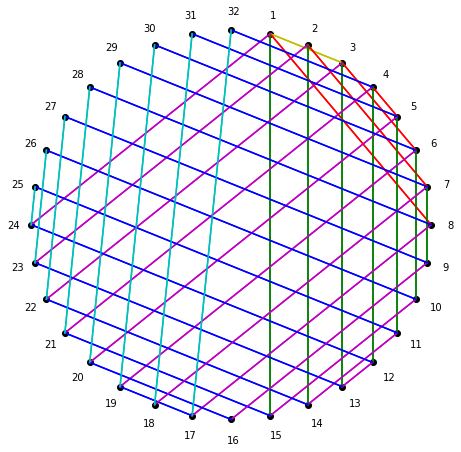

In [24]:
show(adjacency_graph(32))

Degree counts: {2: 32}
Square counts: {9: 2, 16: 4, 25: 6, 36: 12, 49: 8}


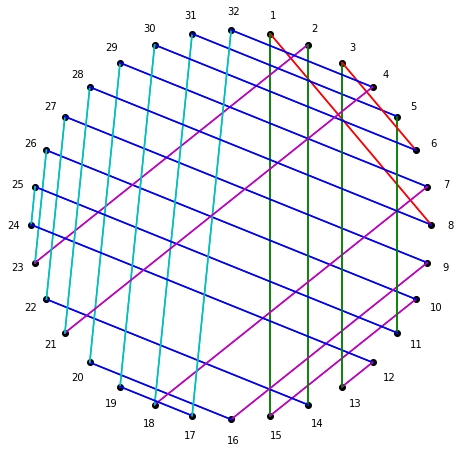

In [25]:
show(first(find_chains(32, circular=True)))

It is interesting that the chain keeps all 8 of the (cyan) links that add up to 49, and 12 of the 14 (blue) links that add up to 36, but that links with lower sums are less likely to appear in the chain.

# Visualizing chains for other numbers
Some more pretty pictures:

Degree counts: {2: 42}
Square counts: {9: 3, 16: 3, 25: 4, 36: 8, 49: 14, 64: 9, 81: 1}


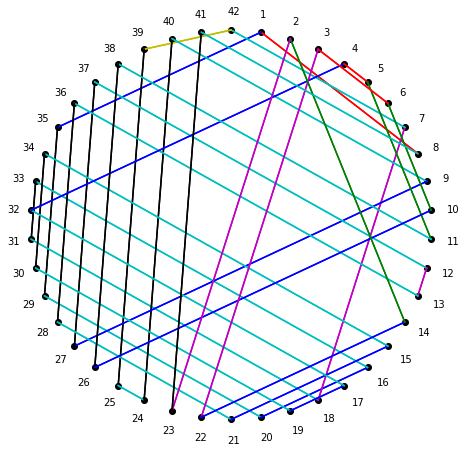

In [26]:
show(first(find_chains(42, True)))

Degree counts: {2: 36}
Square counts: {9: 1, 16: 6, 25: 4, 36: 11, 49: 11, 64: 3}


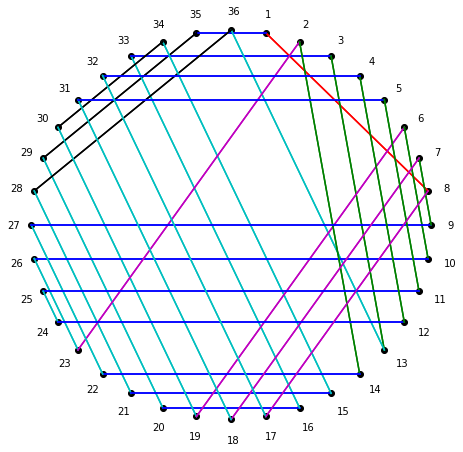

In [27]:
show(first(find_chains(36, True)))

Degree counts: {1: 2, 2: 34}
Square counts: {9: 3, 16: 4, 25: 6, 36: 7, 49: 11, 64: 4}


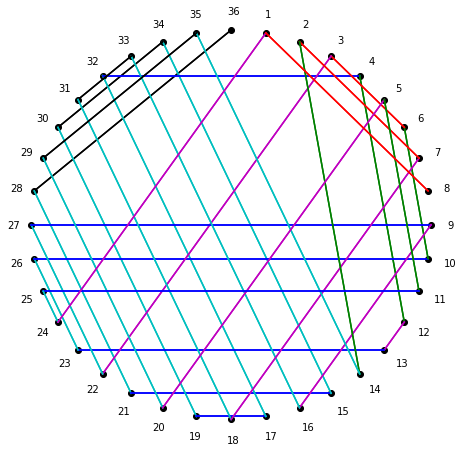

In [28]:
show(first(find_chains(36, False)))

Degree counts: {1: 2, 2: 68}
Square counts: {9: 3, 16: 5, 25: 6, 36: 6, 49: 7, 64: 4, 81: 10, 100: 18, 121: 10}


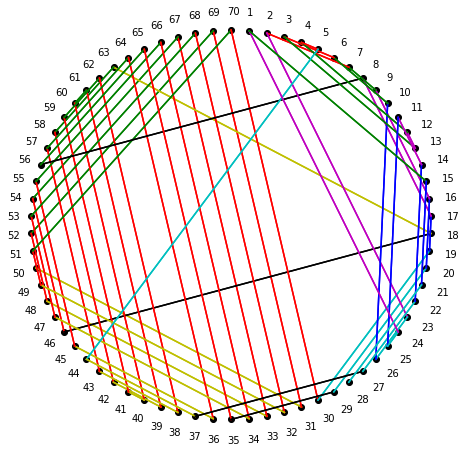

In [29]:
show(first(find_chains(70)))

Degree counts: {2: 1, 3: 8, 4: 33, 5: 16, 6: 10, 7: 2}
Square counts: {4: 1, 9: 4, 16: 7, 25: 12, 36: 17, 49: 24, 64: 31, 81: 30, 100: 20, 121: 10}


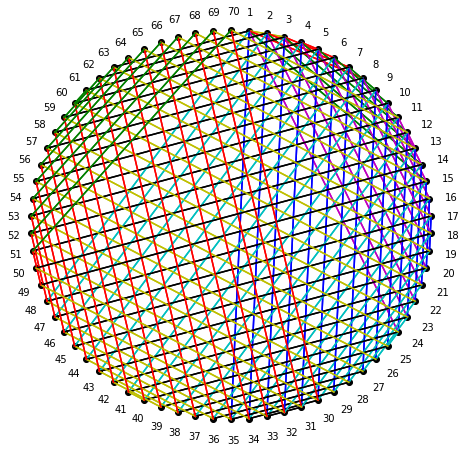

In [30]:
show(adjacency_graph(70))

# Summary over `ints(n)`

The plots above give me some insight into chains for individual values of *n*. Now I want to summarize results over a range of values for *n*, and also show how long the computation takes.

In [31]:
def summarize(nvalues, fn, title):
    times, results = zip(*[timed_result(fn, n) for n in nvalues])
    if set(results).issubset({True, False}):
        trues = [n for (n, r) in zip(nvalues, results) if r]
        print(f'Results True for {summarize_numbers(trues)}')
    else:
        plot(nvalues, results, 'n', 'results', title)
        plt.show()
    plot(nvalues, times, 'n', f'Time in seconds ({sum(times):.1f} total)', title)

def timed_result(fn: callable, *args) -> Tuple[float, object]:
    """The number of seconds it takes to compute fn(*args), and the result."""
    t0 = time.process_time()
    result = fn(*args)
    dt = time.process_time() - t0
    return dt, result
    
def plot(X, Y, xlabel, ylabel, title):
    plt.plot(X, Y, 'o-'); plt.xlabel(xlabel); plt.ylabel(ylabel); plt.title(title)
    
def summarize_numbers(numbers) -> str:
    "Convert, say, [1,2,3,7,8,10], to '1-3, 7-8, 10'."
    return ', '.join(f'{min(g)}{f"-{max(g)}" if len(g) > 1 else ""}'
                     for g in group_consecutive(numbers))

def group_consecutive(numbers):
    """Group numbers into sublists of consecutive integers."""
    groups = []
    for n in sorted(numbers):
        if not groups or n != max(groups[-1]) + 1:
            groups.append([])
        groups[-1].append(n)
    return groups

First, look at finding the first chain for a given *n*, both linear and circular:

Results True for 1, 15-17, 23, 25-74


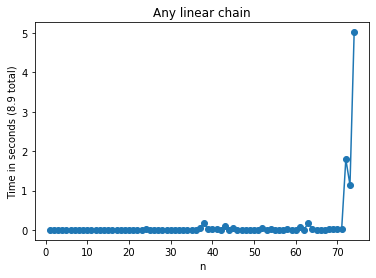

In [32]:
summarize(ints(74), lambda n: any(find_chains(n)),
          'Any linear chain')

Results True for 32-46


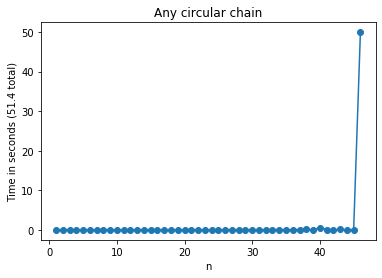

In [33]:
summarize(ints(46), lambda n: any(find_chains(n, circular=True)),
          'Any circular chain')

We see that for linear chains, values of *n* from 15 to 17 yield solutions, as does 23 and values from 25 up. For circular chains, it looks like all values of *n* from 32 up have solutions. (Of course, we have no proof.)

In terms of timing, small values of *n* are fast, and we see a big rise as *n* gets to 74 for linear chains or 46 for circular chains.

Now let's look at the counts of the number of solutions for various values of *n*:

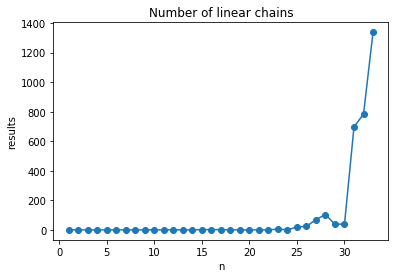

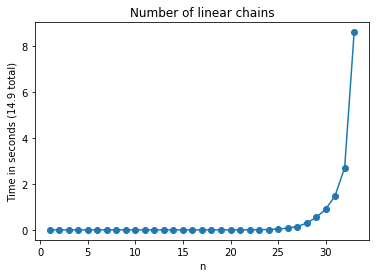

In [34]:
summarize(ints(33), lambda n: length(find_chains(n)),
          'Number of linear chains')

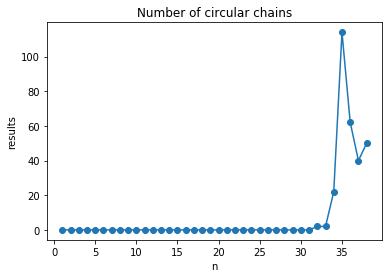

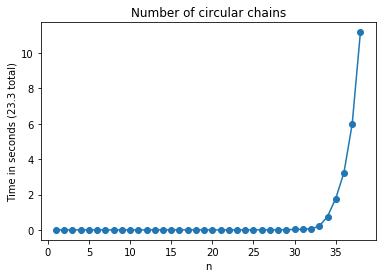

In [35]:
summarize(ints(38), lambda n: length(find_chains(n, circular=True)),
          'Number of circular chains')

There are more linear chains than circular chains. Interestingly, the number of chains does not monotonically increase with *n*.

In terms of timing, it looks like an exponential curve in both cases. Notice that the timing curves are smooth for counting all chains, whereas they were noisy for finding the first chain. That's because finding the first chain depends on luck in the way we search the space of solutions, whereas finsing all solutions means looking at the complete exponential space.